In [20]:
import numpy as np
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import jieba

In [13]:
new_directory = '/Users/yifanwu/Desktop/CSCE915/final_project'
os.chdir(new_directory)
print(os.getcwd())

/Users/yifanwu/Desktop/CSCE915/final_project


In [14]:
file_path_train = './chnsenticorp/train/part.0'
file_path_test = './chnsenticorp/test/part.0'

In [15]:

# Load the data into a DataFrame
data_train = pd.read_csv(file_path_train, sep='\t', header=None, names=['text', 'sentiment'], encoding='utf-8')
data_test = pd.read_csv(file_path_test, sep='\t', header=None, names=['text', 'sentiment'], encoding='utf-8')


# Display the first few rows of the DataFrame to confirm it's loaded correctly
data_train.head(5)


,text,sentiment
0,选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全...,1
1,15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很...,1
2,房间太小。其他的都一般。。。。。。。。。,0
3,"1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸...",0
4,"今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量...",1


In [9]:
data_test.head(5)

,text,sentiment
0,这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般,1
1,怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是...,0
2,还稍微重了点，可能是硬盘大的原故，还要再轻半斤就好了。其他要进一步验证。贴的几种膜气泡较多，...,0
3,交通方便；环境很好；服务态度很好 房间较小,1
4,不错，作者的观点很颠覆目前中国父母的教育方式，其实古人们对于教育已经有了很系统的体系了，可是...,1


In [28]:

# Function to preprocess text
def preprocess_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    # Tokenization
    tokens = jieba.cut(text, cut_all=False)
    
    # Load stop words
    stop_words = {
    '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一个', '上', '也', '很', '到', '说', '要', '去', '你',
    '会', '着', '没有', '看', '好', '自己', '这', '那', '还', '个', '我们', '为', '起', '把', '时', '最', '他', '以', '们', '到',
    '她', '得', '而', '着', '下', '能', '过', '子', '而', '与', '多', '么', '于', '然后', '之', '又', '及', '其', '自', '用', '如何',
    '这些', '它', '对', '也许', '这样', '因为', '而且', '与此同时', '之一', '虽然', '所以', '即使', '然而', '比如', '像', '这里', '要是',
    '哪儿', '那里', '每个', '这个', '那个', '什么', '谁', '几', '多少', '怎么', '怎样', '为什么', '什么', '从', '向', '哪', '难道', '非得',
    '比', '可', '这', '之', '还是', '但', '只', '另', '而已', '除非', '唯有', '假如', '除了', '如果', '但是', '尽管', '只要', '除非'}

    
    # Stop words filtering
    tokens = [token for token in tokens if token not in stop_words]
    
    # Negation handling (example, could be improved based on your data)
    negations = {'不', '没', '无', '非', '莫', '弗', '勿', '毋', '未', '否', '别', '無', '休'}
    tokens = ['NOT_' + token if prev in negations else token for prev, token in zip([''] + tokens[:-1], tokens)]
    
    return ' '.join(tokens)

In [34]:
data_train['text-new'] = data_train['text'].apply(preprocess_text)
data_test['text-new'] = data_test['text'].apply(preprocess_text)

In [35]:
data_train.head(10)

,text,sentiment,text-new
0,选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全...,1,选择 珠江 花园 原因 就是 方便 电动 扶梯 直接 到达 海边 周围 餐馆 食...
1,15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很...,1,15 4 寸 笔记本 键盘 确实 爽 基本 跟 台式机 差不多 蛮 喜欢 数字 ...
2,房间太小。其他的都一般。。。。。。。。。,0,房间 太小 其他 一般
3,"1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸...",0,1 接电源 几分钟 电源适配器 热 不行 2 摄像头 起来 3 ...
4,"今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量...",1,今天 才 知道 这书 还有 第 6 卷 真 有点 郁闷 同一 套书 两种 版本 呢 ...
5,机器背面似乎被撕了张什么标签，残胶还在。但是又看不出是什么标签不见了，该有的都在，怪,0,机器 背面 似乎 被 撕 张 标签 残胶 看不出 标签 不见 该 怪
6,呵呵，虽然表皮看上去不错很精致，但是我还是能看得出来是盗的。但是里面的内容真的不错，我妈爱看...,0,呵呵 表皮 看上去 不错 精致 看得出来 盗 里面 内容 真的 不错 我妈 ...
7,"这本书实在是太烂了,以前听浙大的老师说这本书怎么怎么不对,哪些地方都是误导的还不相信,终于买...",0,本书 实在 太烂 以前 听 浙大 老师 本书 哪些地方 误导 相信 终于 买 一...
8,"地理位置佳，在市中心。酒店服务好、早餐品种丰富。我住的商务数码房电脑宽带速度满意,房间还算干...",1,地理位置 佳 市中心 酒店 服务 早餐 品种 丰富 住 商务 数码 房 电脑...
9,5.1期间在这住的，位置还可以，在市委市政府附近，要去商业区和步行街得打车，屋里有蚊子，虽然...,1,5 1 期间 住 位置 可以 市委 市政府 附近 商业区 步行街 打车 ...


In [36]:
data_test.head(10)

,text,sentiment,text-new
0,这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般,1,宾馆 比较 陈旧 特价 房间 一般 总体 来说 一般
1,怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是...,0,怀着 十分 激动 心情 放映 可是 看着 看着 发现 放映 完毕 后 出现 一集...
2,还稍微重了点，可能是硬盘大的原故，还要再轻半斤就好了。其他要进一步验证。贴的几种膜气泡较多，...,0,稍微 重 点 可能 硬盘 大 原故 还要 再轻 半斤 其他 进一步 验证 贴...
3,交通方便；环境很好；服务态度很好 房间较小,1,交通 方便 环境 服务态度 房间 较 小
4,不错，作者的观点很颠覆目前中国父母的教育方式，其实古人们对于教育已经有了很系统的体系了，可是...,1,不错 作者 观点 颠覆 目前 中国 父母 教育 方式 其实 古 人们 对于 教育 已...
5,有了第一本书的铺垫，读第二本的时候开始进入状态。基本上第二本就围绕主角们的能力训练展开，故事...,1,第一 本书 铺垫 读 第二本 时候 开始 进入状态 基本上 第二本 围绕 主角 能力...
6,前台接待太差，酒店有A B楼之分，本人check－in后，前台未告诉B楼在何处，并且B楼无明...,0,前台 接待 太 差 酒店 A B 楼之分 本人 check in 后 前...
7,1. 白色的，很漂亮，做工还可以； 2. 网上的软件资源非常丰富，这是我买它的最主要原因； ...,1,1 白色 很漂亮 做工 可以 2 网上 软件资源 非常 丰富...
8,在当当上买了很多书，都懒于评论。但这套书真的很好，3册都非常精彩。我家小一的女儿，认字多，非...,1,当当 买 很多 书 懒于 评论 套书 真的 3 册 非常 精彩 我家 小一 ...
9,19天硬盘就罢工了~~~算上运来的一周都没用上15天~~~可就是不能换了~~~唉~~~~你说...,0,19 天 硬盘 罢工 算上 运来 一周 没用 15 天 就是 不能 ...


In [37]:
# Splitting data
X_train = data_train['text-new']
X_test = data_test['text-new']
y_train = data_train['sentiment']
y_test = data_test['sentiment']

In [38]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SVM Classifier
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train_tfidf, y_train)

# Predictions
predictions = svm_classifier.predict(X_test_tfidf)

# Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       592
           1       0.88      0.87      0.88       608

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200



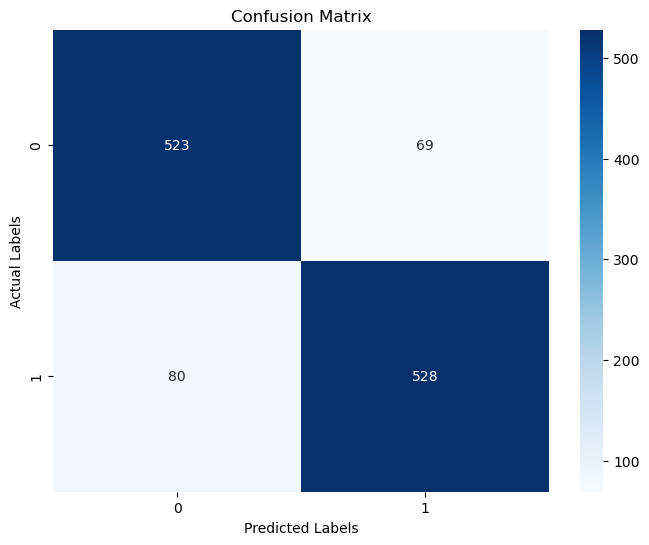

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


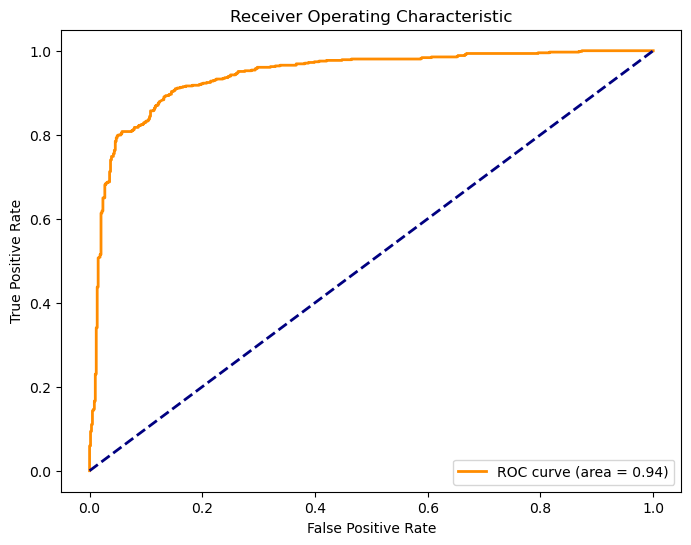

In [40]:
# ROC Curve
prediction_probabilities = svm_classifier.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, prediction_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()